In [ ]:
import re
import json
from difflib import ndiff
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def calculate_levenshtein_distance(str_1, str_2):
    """
        The Levenshtein distance is a string metric for measuring the difference between two sequences.
        It is calculated as the minimum number of single-character edits necessary to transform one string into another
    """
    distance = 0
    buffer_removed = buffer_added = 0
    for x in ndiff(str_1, str_2):
        code = x[0]
        # Code ? is ignored as it does not translate to any modification
        if code == ' ':
            distance += max(buffer_removed, buffer_added)
            buffer_removed = buffer_added = 0
        elif code == '-':
            buffer_removed += 1
        elif code == '+':
            buffer_added += 1
    distance += max(buffer_removed, buffer_added)
    return distance

def removePunctuation(line):
    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    # Removing punctuations in string
    # Using loop + punctuation string
    for ele in line:
        if ele in punc:
            line = line.replace(ele, "")
    return(line)

def findLeftIndex(anchorPoint, sourceWords, sourceTranscriptDict, targetTranscriptDict):
    #Iterate from anchorPoint to 0
    for loop in range(anchorPoint - 1, 0, -1):
        if(sourceWords[loop] in targetTranscriptDict and sourceTranscriptDict[sourceWords[loop]] == targetTranscriptDict[sourceWords[loop]]):
            return loop
    return -1

def findRightIndex(anchorPoint, sourceWords, sourceTranscriptDict, targetTranscriptDict):
    #Iterate from anchorPoint to end
    lenSource = len(sourceWords)
    for loop in range(anchorPoint + 1, lenSource, 1):
        if(sourceWords[loop] in targetTranscriptDict and sourceTranscriptDict[sourceWords[loop]] == targetTranscriptDict[sourceWords[loop]]):
            return loop
    return -1

def getIndividualIndex(wordIndex, word, detailedDict):
    wordDict = detailedDict[word]
    dictLen = len(wordDict)

    for loop in range(0, dictLen, 1):
        if(wordDict[loop] == wordIndex):
            return loop

def getString(leftIndex, rightIndex, words):
    if(leftIndex >= rightIndex):
        return("")

    choppedWords = words[leftIndex:rightIndex+1]
    return(" ".join(choppedWords).strip())



def findMatching(slurWordIndex, sourceTranscript, sourceTranscriptDict, sourceTranscriptDetailedDict, targetTranscript, targetTranscriptDict, targetTranscriptDetailedDict):
    sourceWords = sourceTranscript.split()
    targetWords = targetTranscript.split()

    #print(sourceWords[slurWordIndex])

    sourceLeftIndex = slurWordIndex
    sourceRightIndex = slurWordIndex
    sourceBestLeftIndex = slurWordIndex
    sourceBestRightIndex = slurWordIndex

    #Find the first left and right indices that are perfects

    sourceLeftIndex = findLeftIndex(slurWordIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
    #print(sourceWords[sourceLeftIndex])
    sourceRightIndex = findRightIndex(slurWordIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
    #print(sourceWords[sourceRightIndex])


    #Get individual index of a perfect word
    sourceLeftIndividualIndex = getIndividualIndex(sourceLeftIndex, sourceWords[sourceLeftIndex], sourceTranscriptDetailedDict)
    #print(sourceLeftIndividualIndex)
    sourceRightIndividualIndex = getIndividualIndex(sourceRightIndex, sourceWords[sourceRightIndex], sourceTranscriptDetailedDict)
    #print(sourceRightIndividualIndex)

    #print(targetTranscriptDetailedDict)

    targetLeftIndex = targetTranscriptDetailedDict[sourceWords[sourceLeftIndex]][sourceLeftIndividualIndex]
    #print(targetLeftIndex)
    targetRightIndex = targetTranscriptDetailedDict[sourceWords[sourceRightIndex]][sourceRightIndividualIndex]
    #print(targetRightIndex)

    #Matching perfects are found, now compute the substring and print the substrings

    sourceString = getString(sourceLeftIndex, sourceRightIndex, sourceWords)
    #print(sourceString)
    targetString = getString(targetLeftIndex, targetRightIndex, targetWords)
    #print(targetString)

    bestLevenshtein = calculate_levenshtein_distance(sourceString, targetString)

    bestSourceLeftIndex = sourceLeftIndex
    bestSourceRightIndex = sourceRightIndex
    bestTargetLeftIndex = targetLeftIndex
    bestTargetRightIndex = targetRightIndex
    currentLevenshtein = bestLevenshtein

    #Find potential left expansion indices
    #Find potential right expansion indices
    #compute all three possibilities (e.g., left expansion, unchanged) (unchanged, right expansion) (left expansion, right expansion)
    #if none of these improves the Levenshtein distance, stop

    while(currentLevenshtein <= bestLevenshtein):

        sourceLeftIndex = findLeftIndex(bestSourceLeftIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
        #print(sourceWords[sourceLeftIndex])
        sourceRightIndex = findRightIndex(bestSourceRightIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
        #print(sourceWords[sourceRightIndex])

        #Get individual index of a perfect word
        sourceLeftIndividualIndex = getIndividualIndex(sourceLeftIndex, sourceWords[sourceLeftIndex], sourceTranscriptDetailedDict)
        #print(sourceLeftIndividualIndex)
        sourceRightIndividualIndex = getIndividualIndex(sourceRightIndex, sourceWords[sourceRightIndex], sourceTranscriptDetailedDict)
        #print(sourceRightIndividualIndex)

        targetLeftIndex = targetTranscriptDetailedDict[sourceWords[sourceLeftIndex]][sourceLeftIndividualIndex]
        #print(targetLeftIndex)
        targetRightIndex = targetTranscriptDetailedDict[sourceWords[sourceRightIndex]][sourceRightIndividualIndex]

        #There are three possibilities now

        #left expansion
        sourceString = getString(sourceLeftIndex, bestSourceRightIndex, sourceWords)
        #print(sourceString)
        targetString = getString(targetLeftIndex, bestTargetRightIndex, targetWords)
        #print(targetString)

        leftExpansionLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
        #print(leftExpansionLevenshtein)

        #right expansion
        sourceString = getString(bestSourceLeftIndex, sourceRightIndex, sourceWords)
        #print(sourceString)
        targetString = getString(bestTargetLeftIndex, targetRightIndex, targetWords)
        #print(targetString)

        rightExpansionLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
        #print(rightExpansionLevenshtein)

        #both expansion
        sourceString = getString(sourceLeftIndex, sourceRightIndex, sourceWords)
        #print(sourceString)
        targetString = getString(targetLeftIndex, targetRightIndex, targetWords)
        #print(targetString)

        bothExpansionLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
        #print(bothExpansionLevenshtein)

        currentLevenshtein = min(bothExpansionLevenshtein, leftExpansionLevenshtein, rightExpansionLevenshtein)


        if(currentLevenshtein <= bestLevenshtein):
            bestLevenshtein = currentLevenshtein
            #If left expansion brings in improvement
            if(leftExpansionLevenshtein == currentLevenshtein):
                bestSourceLeftIndex = sourceLeftIndex
                bestTargetLeftIndex = targetLeftIndex

            #If right expansion brings in improvement
            if(rightExpansionLevenshtein == currentLevenshtein):
                bestSourceRightIndex = sourceRightIndex
                bestTargetRightIndex = targetRightIndex

            #If both expansion brings in improvement
            if(bothExpansionLevenshtein == currentLevenshtein):
                bestSourceLeftIndex = sourceLeftIndex
                bestTargetLeftIndex = targetLeftIndex
                bestSourceRightIndex = sourceRightIndex
                bestTargetRightIndex = targetRightIndex

    #left expansion
    sourceString = getString(bestSourceLeftIndex, bestSourceRightIndex, sourceWords)
    #print(sourceString)
    targetString = getString(bestTargetLeftIndex, bestTargetRightIndex, targetWords)
    #print(targetString)
    bestLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
    #print(bestLevenshtein)
    return sourceString, targetString, bestLevenshtein

In [ ]:
def findMatching(slurWordIndex, sourceTranscript, sourceTranscriptDict, sourceTranscriptDetailedDict, targetTranscript, targetTranscriptDict, targetTranscriptDetailedDict):
    sourceWords = sourceTranscript.split()
    targetWords = targetTranscript.split()

    #print(sourceWords[slurWordIndex])

    sourceLeftIndex = slurWordIndex
    sourceRightIndex = slurWordIndex
    sourceBestLeftIndex = slurWordIndex
    sourceBestRightIndex = slurWordIndex

    #Find the first left and right indices that are perfects

    sourceLeftIndex = findLeftIndex(slurWordIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
    #print(sourceWords[sourceLeftIndex])
    sourceRightIndex = findRightIndex(slurWordIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
    #print(sourceWords[sourceRightIndex])


    #Get individual index of a perfect word
    sourceLeftIndividualIndex = getIndividualIndex(sourceLeftIndex, sourceWords[sourceLeftIndex], sourceTranscriptDetailedDict)
    #print(sourceLeftIndividualIndex)
    sourceRightIndividualIndex = getIndividualIndex(sourceRightIndex, sourceWords[sourceRightIndex], sourceTranscriptDetailedDict)
    #print(sourceRightIndividualIndex)

    #print(targetTranscriptDetailedDict)

    targetLeftIndex = targetTranscriptDetailedDict[sourceWords[sourceLeftIndex]][sourceLeftIndividualIndex]
    #print(targetLeftIndex)
    targetRightIndex = targetTranscriptDetailedDict[sourceWords[sourceRightIndex]][sourceRightIndividualIndex]
    #print(targetRightIndex)

    #Matching perfects are found, now compute the substring and print the substrings

    sourceString = getString(sourceLeftIndex, sourceRightIndex, sourceWords)
    #print(sourceString)
    targetString = getString(targetLeftIndex, targetRightIndex, targetWords)
    #print(targetString)

    bestLevenshtein = calculate_levenshtein_distance(sourceString, targetString)

    bestSourceLeftIndex = sourceLeftIndex
    bestSourceRightIndex = sourceRightIndex
    bestTargetLeftIndex = targetLeftIndex
    bestTargetRightIndex = targetRightIndex
    currentLevenshtein = bestLevenshtein

    #Find potential left expansion indices
    #Find potential right expansion indices
    #compute all three possibilities (e.g., left expansion, unchanged) (unchanged, right expansion) (left expansion, right expansion)
    #if none of these improves the Levenshtein distance, stop

    while(currentLevenshtein <= bestLevenshtein):

        sourceLeftIndex = findLeftIndex(bestSourceLeftIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
        #print(sourceWords[sourceLeftIndex])
        sourceRightIndex = findRightIndex(bestSourceRightIndex, sourceWords, sourceTranscriptDict, targetTranscriptDict)
        #print(sourceWords[sourceRightIndex])

        #Get individual index of a perfect word
        sourceLeftIndividualIndex = getIndividualIndex(sourceLeftIndex, sourceWords[sourceLeftIndex], sourceTranscriptDetailedDict)
        #print(sourceLeftIndividualIndex)
        sourceRightIndividualIndex = getIndividualIndex(sourceRightIndex, sourceWords[sourceRightIndex], sourceTranscriptDetailedDict)
        #print(sourceRightIndividualIndex)

        targetLeftIndex = targetTranscriptDetailedDict[sourceWords[sourceLeftIndex]][sourceLeftIndividualIndex]
        #print(targetLeftIndex)
        targetRightIndex = targetTranscriptDetailedDict[sourceWords[sourceRightIndex]][sourceRightIndividualIndex]

        #There are three possibilities now

        #left expansion
        sourceString = getString(sourceLeftIndex, bestSourceRightIndex, sourceWords)
        #print(sourceString)
        targetString = getString(targetLeftIndex, bestTargetRightIndex, targetWords)
        #print(targetString)

        leftExpansionLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
        #print(leftExpansionLevenshtein)

        #right expansion
        sourceString = getString(bestSourceLeftIndex, sourceRightIndex, sourceWords)
        #print(sourceString)
        targetString = getString(bestTargetLeftIndex, targetRightIndex, targetWords)
        #print(targetString)

        rightExpansionLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
        #print(rightExpansionLevenshtein)

        #both expansion
        sourceString = getString(sourceLeftIndex, sourceRightIndex, sourceWords)
        #print(sourceString)
        targetString = getString(targetLeftIndex, targetRightIndex, targetWords)
        #print(targetString)

        bothExpansionLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
        #print(bothExpansionLevenshtein)

        currentLevenshtein = min(bothExpansionLevenshtein, leftExpansionLevenshtein, rightExpansionLevenshtein)


        if(currentLevenshtein <= bestLevenshtein):
            bestLevenshtein = currentLevenshtein
            #If left expansion brings in improvement
            if(leftExpansionLevenshtein == currentLevenshtein):
                bestSourceLeftIndex = sourceLeftIndex
                bestTargetLeftIndex = targetLeftIndex

            #If right expansion brings in improvement
            if(rightExpansionLevenshtein == currentLevenshtein):
                bestSourceRightIndex = sourceRightIndex
                bestTargetRightIndex = targetRightIndex

            #If both expansion brings in improvement
            if(bothExpansionLevenshtein == currentLevenshtein):
                bestSourceLeftIndex = sourceLeftIndex
                bestTargetLeftIndex = targetLeftIndex
                bestSourceRightIndex = sourceRightIndex
                bestTargetRightIndex = targetRightIndex

    #left expansion
    sourceString = getString(bestSourceLeftIndex-20, bestSourceRightIndex+20, sourceWords)
    #print(sourceString)
    targetString = getString(bestTargetLeftIndex-20, bestTargetRightIndex+20, targetWords)
    #print(targetString)
    bestLevenshtein = calculate_levenshtein_distance(sourceString, targetString)
    #print(bestLevenshtein)
    return sourceString, targetString, bestLevenshtein

In [ ]:
df=pd.read_csv("CSV/Data_Final_Full.csv")
df_=pd.read_csv("CSV/Matched Transcripts.csv")

In [ ]:
ids=df['Video Id'].to_list()
ids=[i[:-4] for i in ids]
slurs_list=df['Slur'].to_list()
ids_match=df_['Video Id'].to_list()
am=df_['Amazon'].to_list()
yt=df_['YouTube'].to_list()
start_time=df['Link'].to_list()

transcripts=[]
for i in range(len(ids)):
  item=ids[i]
  if(item in ids_match):
    ind=ids_match.index(item)
    slur=slurs_list[i]
    transcripts.append((am[ind], yt[ind], item, slur, start_time[i]))

In [ ]:
print(transcripts[0][0])
print(transcripts[0][1])
print(transcripts[0][2])
print(transcripts[0][3])
print(transcripts[0][4])
print(len(transcripts))

Yeah Uh huh Yeah No Yeah Welcome to Simple Kids Crafts dot com Episode 675 Makeup transformation Goglia Jobs become scarce Screams We will start this makeup transformation but I will not put any of the materials Why Because I want you to watch the whole video until the end So stay tuned Mhm Mhm We will start our makeup transformation by taking three different types of nail polish dark green white and black And that's how we will need for the makeup transformation on Julia's face I will start by painting the inside of the eye by using white and I'm not going to remove all the makeup just yet because I'm going to guide myself by using the makeup that Julia had previously on her face I'll take a little bit of nail polish remover and a Q tip and I'll start removing the makeup carefully Then I'm going to take a little bit of green and white to make the shade that I want for good idea here And I'm going to start painting her eyes on the upper portion Her problem and then I'm going to paint t

In [ ]:
transcripts_all=[]
length=len(transcripts)
count=0

for id in range(length):
  try:
      googleString =""
      awsString =""

      googleDict = {}
      googleDetailedDict = {}
      googleIndex = 0
      awsIndex = 0
      slur=transcripts[id][3]
      lines=transcripts[id][1]
      modifiedLine = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", lines)
      modifiedLine = removePunctuation(modifiedLine)
      words = modifiedLine.split()

      #Make sure no redundant space in the words

      #Break the line into individual words and create a dictionary
      words = modifiedLine.split()

      for word in words:
          googleString = googleString + " " + word
          if word not in googleDict:
              googleDict[word] = 1
              wordDict = {}
              wordDict[0] = googleIndex
              googleDetailedDict[word] = wordDict
          else:
              googleDict[word] = googleDict[word] + 1
              wordDict = googleDetailedDict[word]
              googleDetailedDict[word][len(wordDict)] = googleIndex

          googleIndex = googleIndex + 1


      #print(googleDict)

      #for ele in googleDict:
      #    print(ele, googleDict[ele])


      awsDict = {}
      awsDetailedDict = {}

      awsTranscript= transcripts[id][0]
      awsTranscript = removePunctuation(awsTranscript)
      awsTranscript =awsTranscript.lower()

      #Break the line into individual words and create a dictionary
      words = awsTranscript.split()

      for word in words:
          awsString = awsString + " " + word
          if word not in awsDict:
              awsDict[word] = 1
              wordDict = {}
              wordDict[0] = awsIndex
              awsDetailedDict[word] = wordDict
          else:
              awsDict[word] = awsDict[word] + 1
              wordDict = awsDetailedDict[word]
              awsDetailedDict[word][len(wordDict)] = awsIndex

          awsIndex = awsIndex + 1

      totalMatch = 0

      for ele in awsDict:
          if ele in googleDict:
              if(awsDict[ele] == googleDict[ele]):
                  totalMatch = totalMatch + 1

      #print(totalMatch / len(awsDict))

      #print(awsDetailedDict)
      #print(calculate_levenshtein_distance(googleString, awsString))


      #We have the googlestring and the awsstring. Now remove any redundant spaces from the Google and AWS string

      googleString = " ".join(googleString.split()).strip()
      awsString = " ".join(awsString.split()).strip()

      #print(googleString)
      #print(awsString)
      #We have all the perfects, detailed dictionary, cleaned up string, we are ready for the next step!

      index_slur=(awsString.split()).index(slur)
      #youtube_, amazon_, c= findMatching(index_slur, googleString, googleDict, googleDetailedDict, awsString, awsDict, awsDetailedDict)
      amazon_, youtube_, c=findMatching(index_slur, awsString, awsDict, awsDetailedDict, googleString, googleDict, googleDetailedDict)
      #transcripts_all.append((transcripts[id][3], transcripts[id][0], amazon_, transcripts[id][1], youtube_, c, transcripts[id][4]))
      #transcripts_all.append((transcripts[id][3], transcripts[id][1], youtube_, transcripts[id][0], amazon_, c, transcripts[id][4]))
      #youtube_, amazon_, c= findMatching(index_slur, googleString, googleDict, googleDetailedDict, awsString, awsDict, awsDetailedDict)
      #amazon_, youtube_, c=findMatching(index_slur, awsString, awsDict, awsDetailedDict, googleString, googleDict, googleDetailedDict)
      transcripts_all.append((transcripts[id][3], transcripts[id][0], amazon_, transcripts[id][1], youtube_, c, transcripts[id][4]))
      #transcripts_all.append((transcripts[id][3], transcripts[id][1], youtube_, transcripts[id][0], amazon_, c, transcripts[id][4]))
  except Exception as e:
   print(e)
   count+=1

'bad'
None
'mm'
'starring'
None
'mhm'
None
'near'
'ass'
'yeah'
'yeah'
'five'
'yeah'
None
'five'
'presents'
None
None
None
'mhm'
None
None
'starring'
'yeah'
'mhm'
'um'
'mhm'
'guy'
'what'
'problem'
'yeah'
'mhm'
None
'hello'
'master'
None
'mhm'
'mhm'
None
None
'mhm'
'back'
None
'mhm'
'right'
'no'
None
None
None
'hey'
None
None
None
None
'wow'
'okay'
None
None
'wow'
None
'sky'
'b'
'because'
'yeah'
None
None
'yeah'
None
'mhm'
'okay'
'mhm'
None
'five'
'yeah'
'mhm'
'mm'
None
None
None
'pasta'
None
'grover'
None
None
None
None
None
None
'mhm'
None
'yeah'
'five'
'mhm'
'emitters'
None
None
'oh'
'five'
'mhm'
'railway'
None
'oh'
'mask'
'mhm'
None
'sucks'
'oh'
'yeah'
'five'
'mhm'
'yours'
None
'hmm'
'yeah'
'yeah'
None
None
None
'byes'
'thing'
None
'yeah'
None
'technology'
None
None
None
'mhm'
'34567'
None
'shit'
None
'by'
'five'
'five'
'okay'
None
'mhm'
None
None
'five'
None
'videos'
'five'
None
'bye'
None
'five'
'five'
'five'
None
None
'mm'
None
None
'five'
'five'
None
'five'
'five'
None
None
'gian

In [ ]:
print(count)

221


In [ ]:
for i in transcripts_all:
  print(i[2], '\n', i[4], '\n')
  break

kind of fabric that is stretchy will work for this and im just trying to match the outfit that sarah has in her anus now we are ready to put our doll together and im going to attach the head for my dog and were going to speed it up a little bit 
 kind of fabric that is stretchy will work for this and Im just trying to match the outfit that scare has in hurry nice now we are ready to put our doll together and Im going to attach the head for my doll and were going to speed it up a little bit 



In [ ]:
df = pd.DataFrame(transcripts_all, columns =['Slur', 'YouTube', 'YouTube Match', 'Amazon', 'Amazon Match', 'Levenshtein Distance', 'Link'])

# saving the dataframe
df.to_csv('CSV/Misc/Dataset_YouTube_Final_Full.csv')

In [ ]:
print(links)

NameError: ignored

In [ ]:
links_final=[]
for id in ids:
  for i in links:
    if id in i:
      links_final.append(i)
      break
print(len(links_final))

In [ ]:
#when amazon is source
yt_match=[i[4] for i in transcripts_all]
am_match=[i[2] for i in transcripts_all]
ids=[i[0] for i in transcripts_all]
lev=[i[5] for i in transcripts_all]
links=[i[6] for i in transcripts_all]
dict_={'Slur':ids, 'YT':yt_match, 'Amazon':am_match, 'Levenshtein':lev, 'Link':links}
df_new=pd.DataFrame(dict_)
df_new.to_csv('CSV/Dataset_Amazon_Final_Extension20.csv')

In [ ]:
yt_match=[i[2] for i in transcripts_all]
am_match=[i[4] for i in transcripts_all]
ids=[i[0] for i in transcripts_all]
lev=[i[5] for i in transcripts_all]
links=[i[6] for i in transcripts_all]
dict_={'Slur':ids, 'YT':yt_match, 'Amazon':am_match, 'Levenshtein':lev, 'Link':links}
df_new=pd.DataFrame(dict_)
df_new.to_csv('CSV/Dataset_YouTube_Final.csv')

In [ ]:
d=pd.read_csv('CSV/Dataset_Amazon_Final.csv')
d1=pd.read_csv('CSV/Dataset_Amazon_Final_Extension10.csv')
d2=pd.read_csv('CSV/Dataset_Amazon_Final_Extension20.csv')

In [ ]:
amazon_1=[]
amazon_2=[]
for i in range(len(d)):
  for x in range(len(d)):
    if(d1['Link'][x] in d['Link'][i]):
      amazon_1.append(d1['Amazon'][x])
      amazon_2.append(d2['Amazon'][x])
      break

In [ ]:
print(len(amazon_1))
print(len(amazon_2))
print(len(d))

2324
2324
2324


In [ ]:
print(d['Amazon'].to_list()[80:100])

['those dumb comments theyre just negative nonsense', 'unlock the door you must bring down that dumbbell using both your strength', 'hopscotch we added a dumbbell by using buttons we have a toilet paper', 'should have never gotten someone so dumb to rob that bank I dont know how are you doing', 'duck pulls away here comes arthur mr conductor tries as hard as duck gets a little bit of boost but its not enough', 'flew down the hill just in time to pass victor that was so super close folks what an exciting', "melting He'll turn to water and disappear", 'raise and lower this heel that wheel turns', 'maybe i could be a hero you mean a heroine yes', 'maybe i could be a hero you mean a heroine yes emma the mighty oh me', 'monsters that seems pretty heroic hey im really fast maybe i could be a hero you mean a heroine yes emma', 'symbol or the his symbol and out pops a little backhoe shovel and this is cool so watch this again so if', 'would just kill me Oh my gosh', 'did a one hit kill again R

In [ ]:
dict_={'Amazon Transcript': d['YouTube'].to_list(), 'Extended by 10': amazon_1, 'Extended by 20': amazon_2, 'Presence':d['Does the audio contain a slur or not?'].to_list(), 'Actual Word': d['Actual Word'].to_list(), 'Slur':d['Slur'].to_list()}

In [ ]:
df_new=pd.DataFrame(dict_)
df_new.to_csv('CSV/Extensions_Combined.csv')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

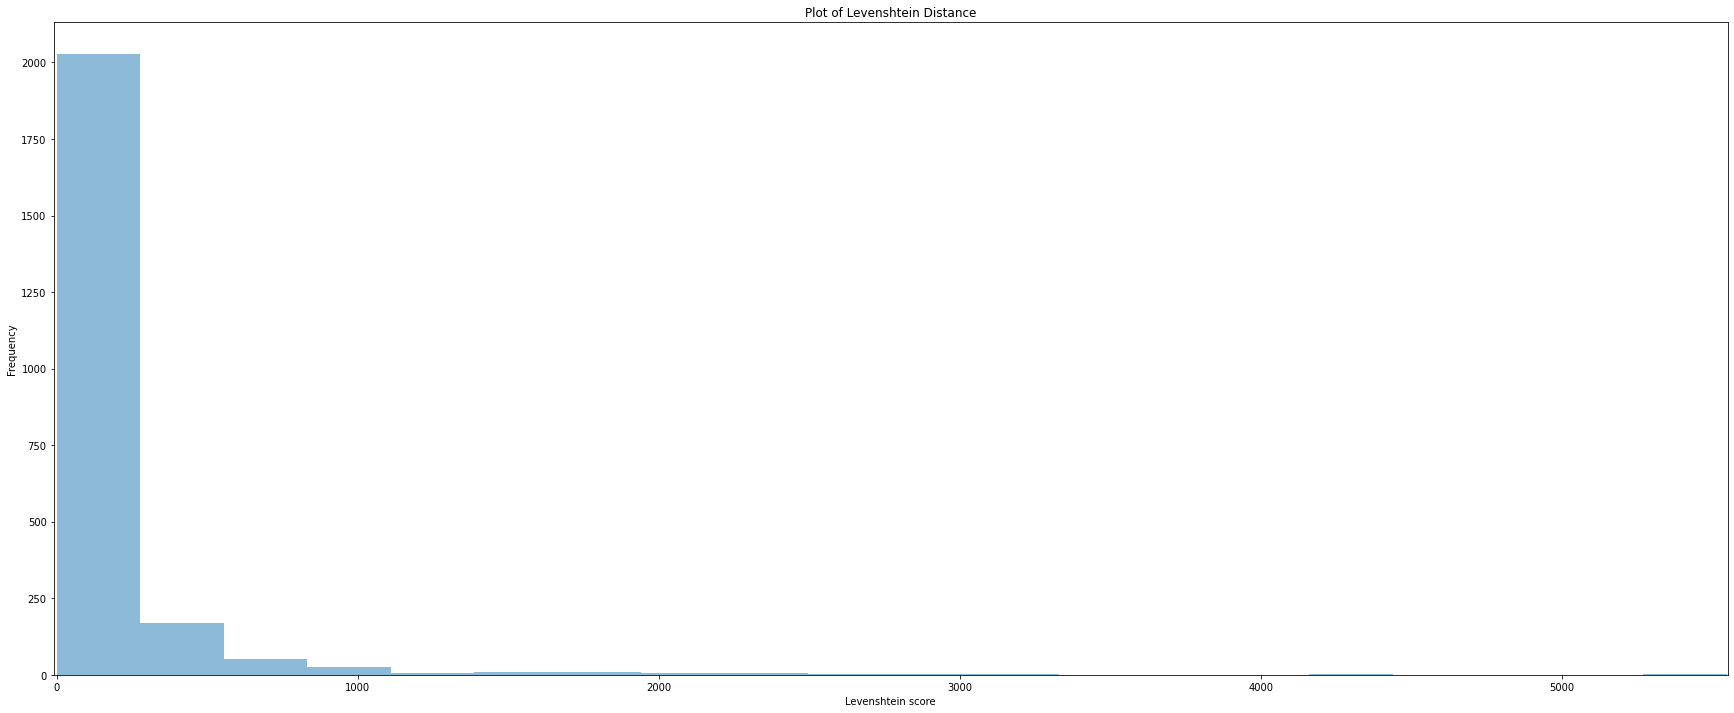

In [ ]:
levenshtein=[i[2] for i in transcripts_all]
levenshtein.sort()
print(levenshtein)

plt.figure(figsize=(30,12))
plt.xlim([min(levenshtein)-10, max(levenshtein)+2])
plt.hist(levenshtein, bins=20, alpha=0.5)
plt.title(f'Plot of Levenshtein Distance')
plt.xlabel('Levenshtein score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
print(len([i for i in levenshtein if i<10]))
print(len([i for i in levenshtein if i<25]))
print(len([i for i in levenshtein if i<50]))
print(len([i for i in levenshtein if i<100]))
print(len(levenshtein))

517
989
1360
1727
2324


In [ ]:
final_addr='Final Results/'
video_ids=[]
transcript_type='Amazon'
df=pd.read_csv('Final Results/Dataset_'+transcript_type+'_Final_2.csv')
for i in range(len(df)):
  actual_word=df['Actual Word'][i]
  if((df['Does the audio contain a slur or not?'][i]!='No') or (actual_word=='[Noises]')):
    continue
  vid_id=str(df['Link'][i])[32:43]
  video_ids.append(vid_id)

In [ ]:
print(len(video_ids))

323


In [ ]:
transcripts_amazon=[]
transcripts_youtube=[]
dict_={}
df=pd.read_csv("CSV/Matched Transcripts.csv")
for i in range(len(df)):
  dict_[df['Video Id'][i]]=(df['Amazon'][i], df['YouTube'][i])

In [ ]:
import math
from collections import Counter

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

def length_similarity(c1, c2):
    lenc1 = sum(c1.values())
    lenc2 = sum(c2.values())
    return min(lenc1, lenc2) / float(max(lenc1, lenc2))

def similarity_score(l1, l2):
    c1, c2 = Counter(l1), Counter(l2)
    return length_similarity(c1, c2) * counter_cosine_similarity(c1, c2)

In [ ]:
values=[]
for i in video_ids:
  try:
    am=dict_[i][0]
    yt=dict_[i][1]
    counterA = Counter(am)
    counterB = Counter(yt)
    value=counter_cosine_similarity(counterA, counterB)
    values.append(value)
    if(value<0.5):
      print(value, ' ', id)
  except Exception as e:
    print(e)
    print(i)

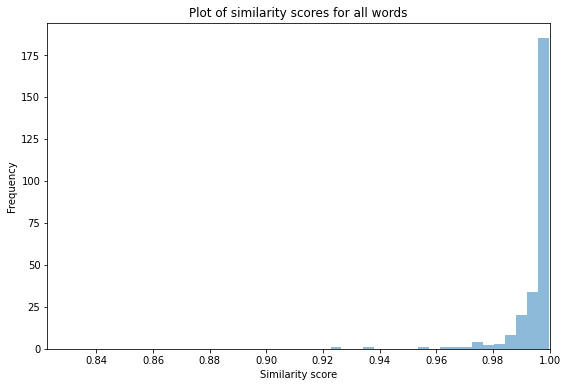

In [ ]:
#YouTube
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize =(9, 6))
plt.xlim([min(values)-0.1, 1])
plt.hist(values, bins=20, alpha=0.5)
plt.title(f'Plot of similarity scores for all words')
plt.xlabel('Similarity score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
print(min(values))
print(max(values))

0.9226670948870699
0.9996534193682741


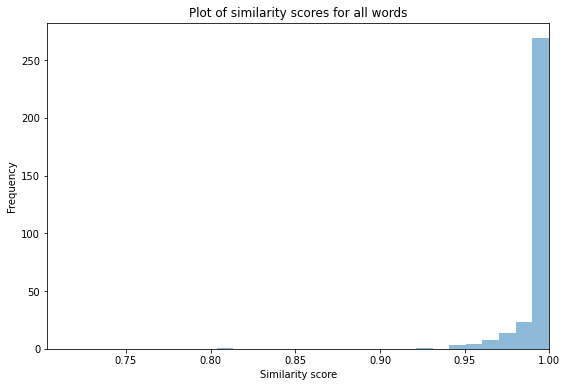

In [ ]:
#Amazon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize =(9, 6))
plt.xlim([min(values)-0.1, 1])
plt.hist(values, bins=20, alpha=0.5)
plt.title(f'Plot of similarity scores for all words')
plt.xlabel('Similarity score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
print(min(values))
print(max(values))

0.8035614076389804
0.9997261485897591


#Matching 1


In [ ]:
import re
import json

from difflib import ndiff

def calculate_levenshtein_distance(str_1, str_2):
    """
        The Levenshtein distance is a string metric for measuring the difference between two sequences.
        It is calculated as the minimum number of single-character edits necessary to transform one string into another
    """
    distance = 0
    buffer_removed = buffer_added = 0
    for x in ndiff(str_1, str_2):
        code = x[0]
        # Code ? is ignored as it does not translate to any modification
        if code == ' ':
            distance += max(buffer_removed, buffer_added)
            buffer_removed = buffer_added = 0
        elif code == '-':
            buffer_removed += 1
        elif code == '+':
            buffer_added += 1
    distance += max(buffer_removed, buffer_added)
    return distance

def removePunctuation(line):
    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    # Removing punctuations in string
    # Using loop + punctuation string
    for ele in line:
        if ele in punc:
            line = line.replace(ele, "")
    return(line)

In [ ]:
import os
csv_youtube=os.listdir("CSV/YouTube")
csv_amazon=os.listdir("CSV/Amazon")

In [ ]:
import pandas as pd
def extract_text(pd_file):
  text=[]
  df=pd.read_csv(pd_file)
  for i in df['Transcript']:
    text.append(str(i))
  return text

In [ ]:
#This part of the code reads a Google transcript. Processes the text to remove punctunation, speaker information, timing information and outputs a dictionary
#of word frequency.
all_transcripts=[]
match_score=[]
video_id=[]
amazon_transcripts=[]
youtube_transcripts=[]
for id in csv_youtube:
  trans=""
  if(id in csv_amazon):
    googleString =""
    awsString =""

    googleDict = {}
    googleDetailedDict = {}
    googleIndex = 0

    lines=extract_text("CSV/YouTube/"+id)
    youtube_transcripts.append(' '.join(lines))
    count = 0
    for line in lines:
        count += 1
        x = line.strip().split(",")

        if(len(x) >= 3): #Timing information is present
            x = x[: len(x) - 2] #Remove the timing information
            modifiedLine = ' '.join(x).strip()
            modifiedLine = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", modifiedLine)
            modifiedLine = removePunctuation(modifiedLine)
            modifiedLine = modifiedLine.strip().lower()
        else: #No timing information
            modifiedLine = ' '.join(x).strip()
            modifiedLine = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", modifiedLine)
            modifiedLine = removePunctuation(modifiedLine)
            modifiedLine = modifiedLine.strip().lower()

        #Break the line into individual words and create a dictionary
        words = modifiedLine.split()

        for word in words:
            googleString = googleString + " " + word
            if word not in googleDict:
                googleDict[word] = 1

            else:
                googleDict[word] = googleDict[word] + 1

            googleIndex = googleIndex + 1


    #print(googleDict)

    #for ele in googleDict:
    #    print(ele, googleDict[ele])


    awsDict = {}
    awsDetailedDict = {}


    awsTranscript= extract_text("CSV/Amazon/"+id)
    awsTranscript=' '.join(awsTranscript)
    amazon_transcripts.append(awsTranscript)

    awsTranscript = removePunctuation(awsTranscript)
    awsTranscript =awsTranscript.lower()

    #Break the line into individual words and create a dictionary
    words = awsTranscript.split()

    for word in words:
        awsString = awsString + " " + word
        if word not in awsDict:
            awsDict[word] = 1
        else:
            awsDict[word] = awsDict[word] + 1

    totalMatch = 0

    for ele in awsDict:
        if ele in googleDict:
            if(awsDict[ele] == googleDict[ele]):
                trans+=ele+' '
                totalMatch = totalMatch + 1
    try:
      print(totalMatch / len(awsDict))
      match_score.append(totalMatch / len(awsDict))
    except:
      match_score.append(0)
    all_transcripts.append(trans)
    video_id.append(id[:-4])

In [ ]:
dict = {'Video Id': video_id, 'Amazon': amazon_transcripts, 'YouTube': youtube_transcripts, 'Matched Transcript':all_transcripts, 'Match Score':match_score}

df = pd.DataFrame(dict)

# saving the dataframe
df.to_csv('CSV/Matched Transcripts.csv')

In [ ]:
print(len(video_id))
print(len(amazon_transcripts))
print(len(youtube_transcripts))
print(len(all_transcripts))
print(len(match_score))

7252
7252
7252
7252
7252


In [ ]:
compString= "He l "
dict_={}
for i in range(len(compString)):
	char=compString[i]
	if(char in dict_):
		dict_[char]+=1
	else:
		dict_[char]=1
count=0

for i in dict_.keys():
	if(dict_[i]==1):
		count+=1
print(count)

3
